## Learning Lyapunov function for Inverted Pendulum

In [1]:
# -*- coding: utf-8 -*-
from dreal import *
from Functions import *
import torch 
import torch.nn.functional as F
import numpy as np
import timeit 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)

## Neural network model
Building NN with random parameters for Lyapunov function and initializing parameters of NN controller to LQR solution

LQR solution is obtained by minimizing the cost function J = ∫(xᵀQx + uᵀRu)dt, where Q is 2×2 identity matrix and R is 1×1 identity matrix

In [2]:
class Net(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output,lqr):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        self.control = torch.nn.Linear(n_input,1,bias=False)
        self.control.weight = torch.nn.Parameter(lqr)

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        u = self.control(x)
        return out,u

## Dynamical system

In [3]:
def f_value(x,u):
    #Dynamics
    y = []
    G = 9.81  # gravity
    L = 0.5   # length of the pole 
    m = 0.15  # ball mass
    b = 0.1   # friction
    
    for r in range(0,len(x)): 
        f = [ x[r][1], 
              (m*G*L*np.sin(x[r][0])- b*x[r][1]) / (m*L**2)]
        y.append(f) 
    y = torch.tensor(y)
    y[:,1] = y[:,1] + (u[:,0]/(m*L**2))
    return y

## Options

In [4]:
'''
For learning 
'''
N = 500             # sample size
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
torch.manual_seed(10)  
x = torch.Tensor(N, D_in).uniform_(-6, 6)           
x_0 = torch.zeros([1, 2])

'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
G = 9.81 
l = 0.5  
m = 0.15
b = 0.1
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2
epsilon = 0
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.5
ball_ub = 6



## Learning and Falsification

In [12]:
out_iters = 0
valid = False
set_prev_weight = True

while out_iters < 2 and not valid: 
    start = timeit.default_timer()
    lqr = torch.tensor([[-23.58639732,  -5.31421063]])    # lqr solution
    model = Net(D_in,H1, D_out,lqr)
    if (set_prev_weight==True) and (out_iters == 0):
        model.load_state_dict(torch.load('savings/model_pendulum.pth'))
    L = []
    i = 0 
    t = 0
    max_iters = 2000
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    while i < max_iters and not valid: 
        V_candidate, u = model(x)
        X0,u0 = model(x_0)
        f = f_value(x,u)
        Circle_Tuning = Tune(x)
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0)

        # With tuning term 
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()\
                    +2.2*((Circle_Tuning-6*V_candidate).pow(2)).mean()+(X0).pow(2) 
        # Without tuning term
#         Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)
        
        
        print(i, "Lyapunov Risk=",Lyapunov_risk.item()) 
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step() 

        w1 = model.layer1.weight.data.numpy()
        w2 = model.layer2.weight.data.numpy()
        b1 = model.layer1.bias.data.numpy()
        b2 = model.layer2.bias.data.numpy()
        q = model.control.weight.data.numpy()

        # Falsification
        if i % 10 == 0:
            u_NN = (q.item(0)*x1 + q.item(1)*x2) 
            f = [ x2,
                 (m*G*l*sin(x1) + u_NN - b*x2) /(m*l**2)]

            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1

            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))

            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            result= CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config,epsilon)
            stop_ = timeit.default_timer() 

            if (result): 
                print("Not a Lyapunov function. Found counterexample: ")
                print(result)
                x = AddCounterexamples(x,result,10)
            else:  
                valid = True
                print("Satisfy conditions!!")
                print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()


    np.savetxt("savings/w1.txt", model.layer1.weight.data, fmt="%s")
    np.savetxt("savings/w2.txt", model.layer2.weight.data, fmt="%s")
    np.savetxt("savings/b1.txt", model.layer1.bias.data, fmt="%s")
    np.savetxt("savings/b2.txt", model.layer2.bias.data, fmt="%s")
    np.savetxt("savings/q.txt", model.control.weight.data, fmt="%s")
    torch.save(model.state_dict(), 'savings/model_pendulum.pth')

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 76.50479944938373
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-1.862104420410434, -1.8620721207387603]
x2 : [-5.7022344447933664, -5.7021656888527641]
1 Lyapunov Risk= 69.16341413465354
2 Lyapunov Risk= 62.36007708626555
3 Lyapunov Risk= 55.81293034532358
4 Lyapunov Risk= 49.56775528161054
5 Lyapunov Risk= 44.29665131694137
6 Lyapunov Risk= 41.212487903523446
7 Lyapunov Risk= 38.87650345341142
8 Lyapunov Risk= 36.59848396345147
9 Lyapunov Risk= 34.028216809942286
10 Lyapunov Risk= 31.0754410175037
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-3.0287680737964351, -3.0187680737964353]
x2 : [3.2831902049940416, 3.2931902049940414]
11 Lyapunov Risk= 28.11013527931367
12 Lyapunov Risk= 25.525291586445228
13 Lyapunov Risk= 23.691813907621604
14 Lyapunov Risk= 22.824909641821495
15 Lyapunov Risk= 22.385044805317335
16 Lyapunov Risk= 21.920500935359463
17 Lyapunov Risk= 21.248410618152743
18 Lyapu

KeyboardInterrupt: 

### Checking result with smaller epsilon ( Lie derivative of V <= epsilon )

In [8]:
epsilon = -0.00001
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config, epsilon)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Satisfy conditions with epsilon=  -1e-05
tanh((0.58310177652736783 + 0.34263702971134929 * tanh((-1.334472535268449 - 0.48113613444572639 * x1 - 0.22039628058035388 * x2)) + 0.99482279118844141 * tanh((-0.88852069279580148 + 0.91112589736028438 * x1 + 0.0074889772650036397 * x2)) + 0.078895339538239836 * tanh((-0.25916138593428611 - 0.63344943010521282 * x1 + 0.40051303082171091 * x2)) + 0.11018080033898039 * tanh((0.25750757218850329 + 0.56171918909995022 * x1 - 0.36966141731461633 * x2)) - 0.75685420699119499 * tanh((0.83215326400607503 + 1.1453973957282626 * x1 - 0.027936427698006576 * x2)) + 1.1676091948328751 * tanh((1.3453778422798393 - 0.051020835000311439 * x1 + 0.039203179702730032 * x2))))  is a Lyapunov function.


### More details on Lyapunov risk
Generally, we start training with Lyapunov risk without the tuning term.      
For example, (1* F.relu(-V_candidate)+ 1.5* F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)    
The weight of each term (1, 1.5, 1.2) can be tuned for balancing each Lyapunov condition.     
Furthermore, using F.relu(L_V+0.5) allows the learning procedure to seek a candidate Lyapunov function with more negative Lie derivative.   
Here 0.5 is also a tunable parameter based on your goal.    
In this example, we use Lyapunov risk with tuning term for achieving large ROA     

In [9]:
eval_env = {x1:0,x2:0}
print(eval_env)
control=V_learn.Evaluate(eval_env)
print(control)

{Variable('x1'): 0, Variable('x2'): 0}
0.08881337191098844


In [10]:

from frictionpendulum import FrictionPendulumEnv
from gym.envs.registration import register
register(
    id='FrictionPendulum-v0',
    entry_point='frictionpendulum:FrictionPendulumEnv',
    max_episode_steps=1000,
    reward_threshold=950.0,
)

In [11]:
import gym
env=gym.make("FrictionPendulum",render_mode="human",g=9.81,dt=0.01, m=0.15, L=0.5, b=0.1,max_speed=100,max_torque=100)
env.reset()
y1=[]
y2=[]
for i in range(1000):
    env.render()
    eval_env = {x1:env.state[0],x2:env.state[1]}
    #print(eval_env)
    control=V_learn.Evaluate(eval_env)
    # print(control)
    y1.append(env.state[0])
    y2.append(env.state[1])
    if i<300:
        control=0
    env.step(np.array([control]))
env.close()

/home/codespace/.python/current/lib/python3.10/site-packages/gym/envs/registration.py:563: UserWarning: WARN: Using the latest versioned environment `FrictionPendulum-v0` instead of the unversioned environment `FrictionPendulum`.
  logger.warn(


error: No available video device

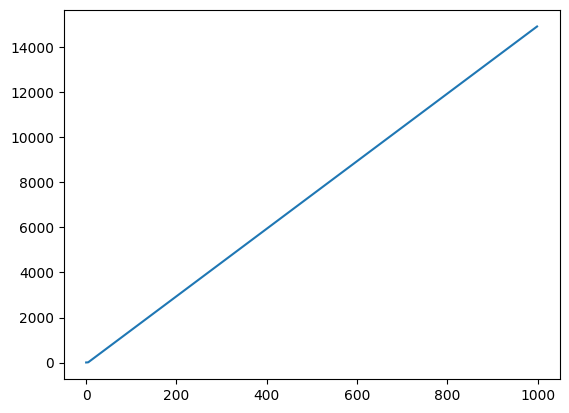

In [47]:
from matplotlib import pyplot
pyplot.plot(y1)

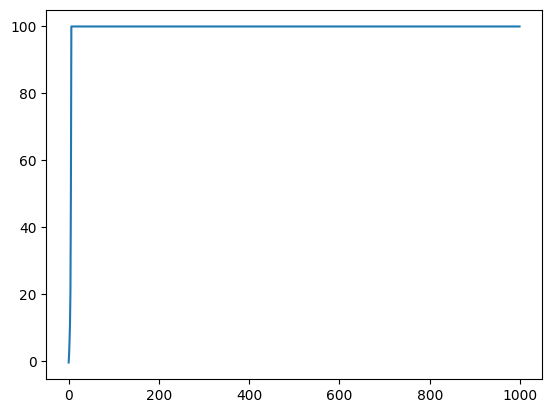

In [48]:
pyplot.plot(y2)